In [25]:
%matplotlib inline

import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import os
import time
from tensorflow.keras.callbacks import TensorBoard


from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle, resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from google.colab import files


# **Data Loading**

In [27]:
def load_data(): # Function to access downloaded data, uploading it to Colab.
  #uploaded = files.upload()
  data = np.load("flatland_train.npz")
  return data['X'], data['y']

In [28]:
X, y = load_data()

Classes and labels:

In [29]:
# Train set contains pictures of the following shapes: circles, triangles, squares, pentagons, and hexagons.

class_names = ['circle', 'triangle', 'square', 'pentagon', 'hexagon']

In [30]:
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
n_class = len(class_names)
print(class_names_label)

{'circle': 0, 'triangle': 1, 'square': 2, 'pentagon': 3, 'hexagon': 4}


In [ ]:
X.shape

(10000, 50, 50)

# **Data vizualizing**


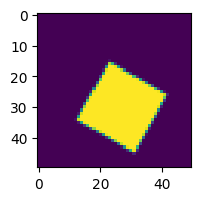

In [ ]:
# Display the image

plt.figure(figsize=(2,2))
plt.imshow(X[3])
plt.show()

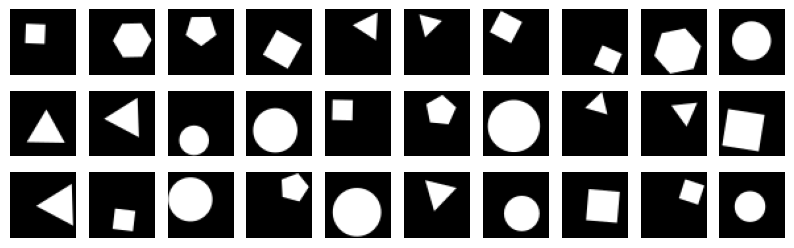

In [ ]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

# **Data (pre)processing**

Processing data for image classification tasks often involves several common techniques. Here are some key types of data processing that we going applied to image datasets:

In [31]:
# 1. Normalization/Scaling
# Scale pixel values to a specific range (e.g., [0, 1]) to ensure uniformity.
# Divide pixel values by the maximum pixel value (e.g., 255 for 8-bit images).

y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1, as shown abowe in class_names

X = X / 255.      # Normalize the pixel values to be between 0 and 1 (scale down to range [0, 1])

In [32]:
# 2. Handling Imbalanced Data
# Address class imbalances in the dataset.
# Use techniques like oversampling (the minority class), undersampling, or class weights during training.

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, X.shape[1] * X.shape[2] ), y)
X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2])

In [33]:
# 3. Shuffle the data

X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

In [34]:
# 4. Splitting Data
# Divide the dataset into training and testing sets.
# Use functions like train_test_split from scikit-learn to split data.

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42) # Split the resampled data into training and testing sets

In [ ]:
# ... Resizing
# Ensure all images have a consistent size.
# Resize images to a predefined height and width using interpolation.

#from skimage.transform import resize

#target_height, target_width = 25, 25  # Choose the desired size
#X_train_resized = np.array([resize(img, (target_height, target_width)) for img in X_train])  # Resize Images
#X_test_resized = np.array([resize(img, (target_height, target_width)) for img in X_test])

# Check
#X_test_resized.shape

In [35]:
# 5. Reshaping
# Reshape data to fit the model


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) # 1 means grayscale
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [36]:
# Check
X_train.shape

(11412, 50, 50, 1)

In [37]:
# 6. One-Hot Encoding (for Classification)
# Convert categorical labels into a binary matrix for multi-class classification.
# Use tools like to_categorical from Keras or scikit-learn's OneHotEncoder.

print("Shape before one-hot encoding: ", y_train.shape)
Y_train = to_categorical(y_train, n_class)   # One-hot encoding using keras' numpy-related utilities
Y_test = to_categorical(y_test, n_class)
print("Shape after: ", Y_train.shape)

Shape before one-hot encoding:  (11412,)
Shape after:  (11412, 5)


In [38]:
# 7. Data Augmentation
# To generate more training examples and potentially improve the model's generalization.
# Increase the diversity of the training set by applying random transformations.
# Rotate, flip, zoom, shear, or shift images randomly during training.

datagen = ImageDataGenerator( # ImageDataGenerator for data augmentation during training

    rotation_range=90,      # random rotation at 90 degrees
    width_shift_range=0.2,  # shift the width of the image 20%
    height_shift_range=0.2, # shift the height of the image 20%
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,   # horizontal transposition
    fill_mode='nearest'

)


# **Model Defining**

In [39]:
# Let's construct, define the CNN and train our model
#Manp
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=[50, 50, 1]),
    #layers.Conv2D(16, (3, 3), activation='relu', input_shape=[50, 50, 1]),
    #layers.Conv2D(32, (3, 3), activation='relu', input_shape=[25, 25, 1]),

    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Conv2D(32, kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2),strides=1),

    layers.Conv2D(64, kernel_size=(3, 3)),
    MaxPooling2D(pool_size=(2, 2),strides=1),

    #layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    Dropout(0.2),
    layers.Dense(5, activation='softmax')  # Assuming it's a classification task
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 18, 18, 64)       

# **Training**

In [ ]:
# Train the model using the training data.

loss = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
286/286 [==============================] - 47s 164ms/step - loss: 0.1446 - accuracy: 0.9783 - val_loss: 0.1287 - val_accuracy: 0.9820
Epoch 2/10
286/286 [==============================] - 45s 159ms/step - loss: 0.1068 - accuracy: 0.9806 - val_loss: 0.1387 - val_accuracy: 0.9812
Epoch 3/10
286/286 [==============================] - 47s 166ms/step - loss: 0.0855 - accuracy: 0.9798 - val_loss: 0.1514 - val_accuracy: 0.9816
Epoch 4/10
286/286 [==============================] - 45s 159ms/step - loss: 0.0800 - accuracy: 0.9803 - val_loss: 0.1543 - val_accuracy: 0.9785
Epoch 5/10
159/286 [===============>..............] - ETA: 19s - loss: 0.0765 - accuracy: 0.9801

In [45]:
# Include data augmentation and fit the model.

batch_size = 32
epochs = 10
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size, epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/10
356/356 [==============================] - 84s 237ms/step - loss: 0.2008 - accuracy: 0.9629 - val_loss: 0.1341 - val_accuracy: 0.9881
Epoch 2/10
356/356 [==============================] - 66s 184ms/step - loss: 0.2069 - accuracy: 0.9630 - val_loss: 0.1652 - val_accuracy: 0.9723
Epoch 3/10
356/356 [==============================] - 65s 181ms/step - loss: 0.1889 - accuracy: 0.9666 - val_loss: 0.1320 - val_accuracy: 0.9884
Epoch 4/10
356/356 [==============================] - 66s 185ms/step - loss: 0.2020 - accuracy: 0.9629 - val_loss: 0.1234 - val_accuracy: 0.9884
Epoch 5/10
356/356 [==============================] - 65s 183ms/step - loss: 0.1999 - accuracy: 0.9626 - val_loss: 0.1303 - val_accuracy: 0.9853
Epoch 6/10
356/356 [==============================] - 66s 186ms/step - loss: 0.1974 - accuracy: 0.9661 - val_loss: 0.1062 - val_accuracy: 0.9884
Epoch 7/10
356/356 [==============================] - 68s 190ms/step - loss: 0.1875 - accuracy: 0.9690 - val_loss: 0.1367 - val_ac

# **Evaluating**

In [46]:
# Evaluate the model on the test set and check accuracy.

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

90/90 [==============================] - 3s 32ms/step - loss: 0.1241 - accuracy: 0.9881
Test Accuracy: 0.9880827069282532


# **Saving**

In [48]:
# Save the model.

model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 3s 31ms/step
Accuracy on test set - 98.81%


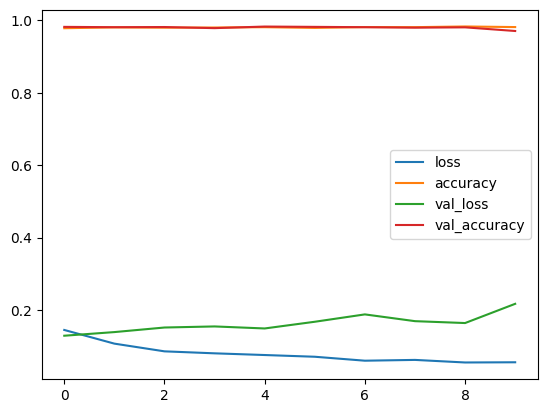

In [47]:
pd.DataFrame(loss.history).plot()
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

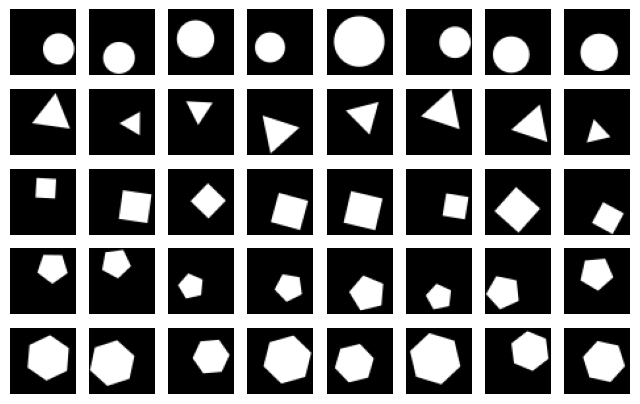

In [ ]:
# Let’s explore some predictions.

plt.figure(figsize=(8, 5))
for label in range(5):
    for i in range(8):
        plt.subplot(5, 8, label * 8 + i + 1)
        plt.imshow(X_test[pred == label][i], cmap='gray')
        plt.axis('off')
plt.show()

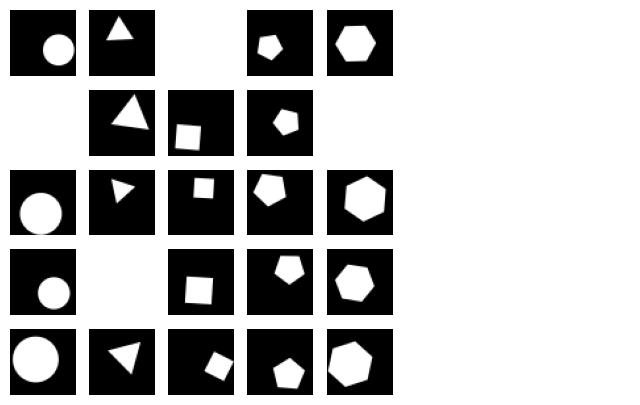

In [ ]:
# Let’s look only at misclassifiesd cases.

plt.figure(figsize=(8, 5))
for label in range(5):
    for i in range(8):
        plt.subplot(5, 8, label * 8 + i + 1)
        mask = (pred == i) & (y_test == label)
        if mask.sum() > 0:
            plt.imshow(X_test[mask][0], cmap='gray')
        plt.axis('off')
plt.show()

Confusion matrix:

In [ ]:
pd.DataFrame(confusion_matrix(y_test, pred)).style.background_gradient(axis=None)

,0,1,2,3,4
0,571,1,0,6,2
1,0,586,1,2,0
2,2,2,530,1,2
3,2,0,2,554,2
4,1,2,5,1,578
